In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155062 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
import librosa
import os
import pandas as pd
import glob
import numpy as np
import soundfile
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
def extract_feature(file_name,mfcc,chroma,mel,zcr,rmse):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype= np.float32)
        sample_rate=sound_file.samplerate
        stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        if zcr:
            zcr=np.mean(librosa.feature.zero_crossing_rate(y=X, frame_length=2048, hop_length=512).T,axis=0)
            result=np.hstack((result, zcr))
        if rmse:
            rmse=np.mean(librosa.feature.rms(S=stft,frame_length=2048, hop_length=512, pad_mode='reflect').T,axis=0)
            result=np.hstack((result, rmse))
    return result

In [31]:
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("/content/drive/My Drive/Emo-DB/Emo-DB/wav/*.wav"):
        file_name=os.path.basename(file)
        emotion=file_name[5]
        if emotion=='W':
          e='anger'
        if emotion=='L':
          e='boredom'
        if emotion=='E':
          e='disgust'
        if emotion=='A':
          e='fear'
        if emotion=='F':
          e='happiness'
        if emotion=='T':
          e='sadness'
        if emotion=='N':
          e='neutral'
        feature=extract_feature(file,mfcc=True,chroma=True,mel=True,zcr=True,rmse=True)
        x.append(feature)
        y.append(e)
    return train_test_split(np.array(x), y, test_size=test_size)

In [36]:
x_train,x_test,y_train,y_test=load_data(test_size=0.2)

In [37]:
x_train.shape,x_test.shape

((388, 182), (97, 182))

In [38]:
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [39]:
y_train=np.array(y_train)
y_test=np.array(y_test)

In [40]:
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [41]:
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]
x_train.shape

(388, 182, 1)

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

#BUILD 1D CNN LAYERS
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(x_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='sigmoid'))
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 173, 64)           704       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 164, 128)          82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 11, 128)           163968    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 128)            0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [43]:
import tensorflow.keras as keras
model_history=model.fit(x_train, y_train,batch_size=32, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
13/13 [==============================] - 2s 104ms/step - loss: 5.7949 - accuracy: 0.1933 - val_loss: 2.5659 - val_accuracy: 0.3608
Epoch 2/100
13/13 [==============================] - 1s 85ms/step - loss: 3.4578 - accuracy: 0.2474 - val_loss: 2.4560 - val_accuracy: 0.4330
Epoch 3/100
13/13 [==============================] - 1s 83ms/step - loss: 2.9455 - accuracy: 0.2990 - val_loss: 2.3385 - val_accuracy: 0.4433
Epoch 4/100
13/13 [==============================] - 1s 83ms/step - loss: 2.6821 - accuracy: 0.2887 - val_loss: 2.2530 - val_accuracy: 0.4433
Epoch 5/100
13/13 [==============================] - 1s 83ms/step - loss: 2.5216 - accuracy: 0.3505 - val_loss: 2.1461 - val_accuracy: 0.4948
Epoch 6/100
13/13 [==============================] - 1s 85ms/step - loss: 2.4505 - accuracy: 0.3660 - val_loss: 2.0292 - val_accuracy: 0.5155
Epoch 7/100
13/13 [==============================] - 1s 83ms/step - loss: 2.3353 - accuracy: 0.4046 - val_loss: 2.0102 - val_accuracy: 0.5258
Epoch

In [44]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

4/4 [==============================] - 0s 14ms/step - loss: 0.6895 - accuracy: 0.7938
Loss of the model is -  0.6895436644554138
4/4 [==============================] - 0s 14ms/step - loss: 0.6895 - accuracy: 0.7938
Accuracy of the model is -  79.38144207000732 %


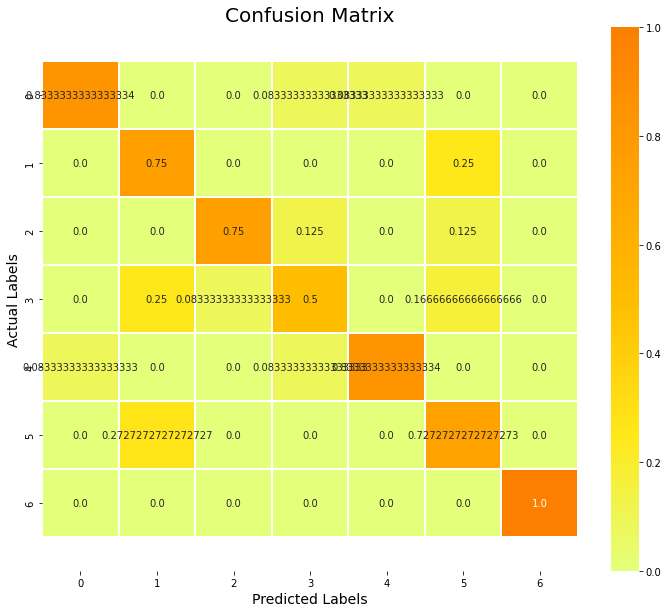

In [59]:
predictions = model.predict(x_test)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
cm = confusion_matrix(actual, predictions,normalize='true')
plt.figure(figsize = (12, 10))
conf_matrix= pd.DataFrame(cm,columns=None)
ax = sns.heatmap(cm, linecolor='white', cmap='Wistia', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

In [46]:
print(classification_report(actual, predictions, target_names = ['anger','boredom','disgust','fear','happiness','neutral','sadness']))

              precision    recall  f1-score   support

       anger       0.95      0.83      0.89        24
     boredom       0.60      0.75      0.67        12
     disgust       0.86      0.75      0.80         8
        fear       0.60      0.50      0.55        12
   happiness       0.83      0.83      0.83        12
     neutral       0.57      0.73      0.64        11
     sadness       1.00      1.00      1.00        18

    accuracy                           0.79        97
   macro avg       0.77      0.77      0.77        97
weighted avg       0.81      0.79      0.80        97



In [47]:
from imblearn.metrics import specificity_score
s=specificity_score(actual,predictions,average='macro')
print(s)

0.9663030717654476


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [48]:
from sklearn.metrics import roc_auc_score
y_score=model.predict(x_test)
auc=roc_auc_score(y_test, y_score, average='macro',multi_class='ovo')
print(auc)

0.9180405530785093


In [49]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
p=precision_score(actual,predictions,average='macro')
r=recall_score(actual,predictions,average='macro')
f=f1_score(actual,predictions,average='macro')
print(p,r,f)

0.7734693877551021 0.7705627705627707 0.7677633477633476


In [50]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print(TPR)
print(FPR)

[0.83333333 0.75       0.75       0.5        0.83333333 0.72727273
 1.        ]
[0.01388889 0.08712121 0.01388889 0.04861111 0.01388889 0.09027778
 0.        ]


In [51]:
l=[]
for i in range(100):
  l.append(i+1)

In [55]:
from pandas import DataFrame
C = {'epoch no':l,
    'acc train':model_history.history['accuracy'],
    'acc val':model_history.history['val_accuracy'],
    'loss train':model_history.history['loss'],
    'loss val':model_history.history['val_loss']}
df = DataFrame(C, columns= ['epoch no','acc train','acc val','loss train','loss val'])
# export_csv = df.to_csv (r'C:\Users\29271\Desktop\5452result\result1.csv', index = None, header=True) 
print (df)

    epoch no  acc train   acc val  loss train  loss val
0          1   0.193299  0.360825    5.794874  2.565885
1          2   0.247423  0.432990    3.457821  2.456042
2          3   0.298969  0.443299    2.945467  2.338457
3          4   0.288660  0.443299    2.682068  2.252993
4          5   0.350515  0.494845    2.521607  2.146095
..       ...        ...       ...         ...       ...
95        96   0.860825  0.731959    0.601968  0.842604
96        97   0.845361  0.783505    0.605114  0.719305
97        98   0.842784  0.793814    0.667219  0.705062
98        99   0.863402  0.824742    0.582827  0.671892
99       100   0.824742  0.793814    0.670647  0.689544

[100 rows x 5 columns]


In [53]:
from pandas import DataFrame
C = {
     'train acc':[str(model_history.history['accuracy'][99])],
     'test acc':[str(model_history.history['val_accuracy'][99])],
     'precision(macro)':[str(p)],
     'recall(macro)':[str(r)],
     'f1(macro)':[str(f)],
     'specificity(macro)':[str(s)],
     'AUC(macro)':[str(auc)],
     'train time per epoch':['1 sec'],
     'test time per epoch':['1 sec'],}
df = DataFrame(C, columns= ['train acc','test acc','precision(macro)','recall(macro)','f1(macro)','specificity(macro)','AUC(macro)','train time per epoch','test time per epoch'])
export_csv = df.to_csv (r'C:\result2.csv', index = None, header=True) 
print (df)

            train acc  ... test time per epoch
0  0.8247422575950623  ...               1 sec

[1 rows x 9 columns]


In [56]:
from pandas import DataFrame
C = {
     'TPR': TPR,
     'FPR': FPR}
df = DataFrame(C, columns= ['TPR','FPR'])
#export_csv = df.to_csv (r'C:\result3.csv', index = None, header=True) 
print (df)

        TPR       FPR
0  0.833333  0.013889
1  0.750000  0.087121
2  0.750000  0.013889
3  0.500000  0.048611
4  0.833333  0.013889
5  0.727273  0.090278
6  1.000000  0.000000
